<a href="https://colab.research.google.com/github/JimEverest/CAM/blob/main/Extra_Chapter_Hook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hook


Hook 是 PyTorch 中一个十分有用的特性。利用它，我们可以不必改变网络输入输出的结构，方便地获取、改变网络中间层变量的值和梯度。这个功能被广泛用于可视化神经网络中间层的 feature、gradient，从而诊断神经网络中可能出现的问题，分析网络有效性。本文将结合代码，由浅入深地介绍 pytorch 中 hook 的用法。

```
1.Hook for Tensors ：针对 Tensor 的 hook

2.Hook for Modules：针对例如 nn.Conv2dnn.Linear等网络模块的 hook
```


## How to retain gradient for non-leaf nodes?

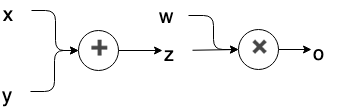

In [ ]:
import torch

x = torch.Tensor([0, 1, 2, 3]).requires_grad_()
y = torch.Tensor([4, 5, 6, 7]).requires_grad_()
w = torch.Tensor([1, 2, 3, 4]).requires_grad_()
z = x+y
# z.retain_grad()
o = w.matmul(z)
print(o)
o.backward()
# o.retain_grad()

In [ ]:
print('x.requires_grad:', x.requires_grad) # True
print('y.requires_grad:', y.requires_grad) # True
print('z.requires_grad:', z.requires_grad) # True
print('w.requires_grad:', w.requires_grad) # True
print('o.requires_grad:', o.requires_grad) # True

x.requires_grad: True
y.requires_grad: True
z.requires_grad: True
w.requires_grad: True
o.requires_grad: True


由于 z 和 o 为中间变量（并非直接指定数值的变量，而是由别的变量计算得到的变量），它们虽然 requires_grad 的参数都是 True，
但是反向传播后，它们的梯度并没有保存下来，而是直接删除了，因此是 None。
<br>

In [ ]:
print('x.grad:', x.grad) # tensor([1., 2., 3., 4.])
print('y.grad:', y.grad) # tensor([1., 2., 3., 4.])
print('w.grad:', w.grad) # tensor([ 4.,  6.,  8., 10.])
print('z.grad:', z.grad) # None
print('o.grad:', o.grad) # None

x.grad: tensor([1., 2., 3., 4.])
y.grad: tensor([1., 2., 3., 4.])
w.grad: tensor([ 4.,  6.,  8., 10.])
z.grad: None
o.grad: None


<ipython-input-10-92c914bf4f6d>:4: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  print('z.grad:', z.grad) # None
<ipython-input-10-92c914bf4f6d>:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/

如果想在反向传播之后保留它们的梯度，则需要特殊指定：把上面代码中的`z.retain_grad() 和 o.retain_grad`的注释去掉，可以得到它们对应的梯度，

In [ ]:
x = torch.Tensor([0, 1, 2, 3]).requires_grad_()
y = torch.Tensor([4, 5, 6, 7]).requires_grad_()
w = torch.Tensor([1, 2, 3, 4]).requires_grad_()
z = x+y
z.retain_grad()
o = w.matmul(z)
print(o)
o.backward()
o.retain_grad()

print('x.requires_grad:', x.requires_grad) # True
print('y.requires_grad:', y.requires_grad) # True
print('z.requires_grad:', z.requires_grad) # True
print('w.requires_grad:', w.requires_grad) # True
print('o.requires_grad:', o.requires_grad) # True

tensor(80., grad_fn=<DotBackward0>)
x.requires_grad: True
y.requires_grad: True
z.requires_grad: True
w.requires_grad: True
o.requires_grad: True


## Hook for Tensors

> 但是，这种加 retain_grad() 的方案会增加内存占用，并不是个好办法，对此的一种替代方案，就是用 hook 保存中间变量的梯度。

>对于中间变量z，hook 的使用方式为：`z.register_hook(hook_fn)`，其中 hook_fn为一个用户自定义的函数，其签名为：
```
hook_fn(grad) 
  return Tensor or None
```

<b>输入</b>为变量 <font color="red">z 的梯度</font> ，

<b>输出</b>为一个 <font color="red">Tensor</font> 或者是 None （None 一般用于直接打印梯度）。

反向传播时，梯度传播到变量 z，再继续向前传播之前，将会传入 <font color="red">hook_fn</font>。

如果hook_fn的返回值是 None，那么梯度将不改变，继续向前传播，仅仅是打印梯度：

In [ ]:
import torch

x = torch.Tensor([0, 1, 2, 3]).requires_grad_()
y = torch.Tensor([4, 5, 6, 7]).requires_grad_()
w = torch.Tensor([1, 2, 3, 4]).requires_grad_()
z = x+y

# ===================
# 1. define hook function
def hook_fn(grad):
    print(grad)

# 2. find the injection Point to hook up. (a non-leaf node tensor)
z.register_hook(hook_fn)
# ===================

o = w.matmul(z)

print('=====Start backprop=====')
o.backward() # tensor([1., 2., 3., 4.])
print('=====End backprop=====')

print('x.grad:', x.grad) # x.grad: tensor([1., 2., 3., 4.])
print('y.grad:', y.grad) # y.grad: tensor([1., 2., 3., 4.])
print('w.grad:', w.grad) # w.grad: tensor([ 4.,  6.,  8., 10.])
print('z.grad:', z.grad) # z.grad: None

# z绑定了hook_fn后，梯度反向传播时将会打印出 o 对 z 的偏导，和上文中z.retain_grad()方法得到的 z 的偏导一致。


=====Start backprop=====
tensor([1., 2., 3., 4.])
=====End backprop=====
x.grad: tensor([1., 2., 3., 4.])
y.grad: tensor([1., 2., 3., 4.])
w.grad: tensor([ 4.,  6.,  8., 10.])
z.grad: None


<ipython-input-12-588a09eb5e96>:26: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  print('z.grad:', z.grad)


如果 hook_fn的返回值是 Tensor 类型，则该 Tensor 将取代 z 原有的梯度，向前传播。

In [ ]:
import torch

x = torch.Tensor([0, 1, 2, 3]).requires_grad_()
y = torch.Tensor([4, 5, 6, 7]).requires_grad_()
w = torch.Tensor([1, 2, 3, 4]).requires_grad_()
z = x + y


# ===================
def hook_fn(grad):
    g = 2 * grad
    print(g)
    return g


z.register_hook(hook_fn)
# ===================

o = w.matmul(z)

print('=====Start backprop=====')
o.backward() # tensor([2., 4., 6., 8.])
print('=====End backprop=====')

print('x.grad:', x.grad) # x.grad: tensor([2., 4., 6., 8.])
print('y.grad:', y.grad) # y.grad: tensor([2., 4., 6., 8.])
print('w.grad:', w.grad) # w.grad: tensor([ 4.,  6.,  8., 10.])
print('z.grad:', z.grad) # z.grad: None

#  z 的梯度变为两倍后，受其影响，x和y的梯度也都变成了原来的两倍。

=====Start backprop=====
tensor([2., 4., 6., 8.])
=====End backprop=====
x.grad: tensor([2., 4., 6., 8.])
y.grad: tensor([2., 4., 6., 8.])
w.grad: tensor([ 4.,  6.,  8., 10.])
z.grad: None


<ipython-input-13-5902f6a93dfb>:28: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  print('z.grad:', z.grad)


## Hook for Modules
> 最常用的 hook 使用场景一般是针对神经网络模块的

module 不像上一节中的 Tensor，拥有显式的变量名可以直接访问

而是被封装在神经网络中间。我们通常只能获得网络整体的输入和输出，对于夹在网络中间的模块，<br/>我们不但很难得知它输入/输出的梯度，甚至连它输入输出的数值都无法获得。

除非设计网络时，在 forward 函数的返回值中包含中间 module 的输出，

或者用很麻烦的办法，把网络按照 module 的名称拆分再组合，让中间层提取的 feature 暴露出来。

<hr>
为了解决这个麻烦，PyTorch 设计了两种 hook：

`register_forward_hook` 和`register_backward_hook`

分别用来获取正/反向传播时，中间层模块输入和输出的 feature/gradient，大大降低了获取模型内部信息流的难度。





### register forward hook

`register_forward_hook`的作用是获取前向传播过程中，各个网络模块的输入和输出。

对于模块module，其使用方式为：<font color="red">`module.register_forward_hook(hook_fn)`</font> 。其中 hook_fn的签名为：

```
hook_fn(module, input, output)
  return None
```
它的输入变量分别为：`模块`，`模块的输入`，`模块的输出`，

和对 Tensor 的 hook 不同，forward hook 不返回任何值，

也就是说不能用它来修改输入或者输出的值，但借助这个 hook，我们可以<font color="red">`方便地用预训练的神经网络提取特征，而不用改变预训练网络的结构`。</font>

下面提供一段示例代码：

In [ ]:
import torch
from torch import nn


class Model(nn.Module):
    def __init__(self): # fc1 --> relu --> fc2
        super(Model, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(4, 1)
        self.initialize()           
    
    # 为了方便验证，指定特殊的weight和bias
    def initialize(self):
        with torch.no_grad():
            self.fc1.weight = torch.nn.Parameter(
                torch.Tensor([[1., 2., 3.],
                        [-4., -5., -6.],
                        [7., 8., 9.],
                        [-10., -11., -12.]]))

            self.fc1.bias = torch.nn.Parameter(torch.Tensor([1.0, 2.0, 3.0, 4.0]))
            self.fc2.weight = torch.nn.Parameter(torch.Tensor([[1.0, 2.0, 3.0, 4.0]]))
            self.fc2.bias = torch.nn.Parameter(torch.Tensor([1.0]))

    def forward(self, x):
        o = self.fc1(x)
        o = self.relu1(o)
        o = self.fc2(o)
        return o


# 全局变量，用于存储中间层的 feature
total_feat_out = []
total_feat_in = []

# 定义 forward hook function
def hook_fn_forward(module, input, output):
    print(module) # 用于区分模块
    print('input', input) # 首先打印出来
    print('output', output)
    total_feat_out.append(output) # 然后分别存入全局 list 中
    total_feat_in.append(input)


model = Model()

modules = model.named_children()   #[   ('fc1', Linear(in_features=3, out_features=4, bias=True) ),     ('relu1', ReLU() ),     ('fc2', Linear(in_features=4, out_features=1, bias=True) )     ]

for name, module in modules:
    module.register_forward_hook(hook_fn_forward)
    # module.register_backward_hook(hook_fn_backward)

# 注意下面代码中 x 的维度，对于linear module，输入一定是大于等于二维的
# （第一维是 batch size）。在 forward hook 中看不出来，但是 backward hook 中， 得到的梯度完全不对。

x = torch.Tensor([[1.0, 1.0, 1.0]]).requires_grad_() # torch.Size([1, 3])
o = model(x)
o.backward()

print('==========Saved inputs and outputs==========')
for idx in range(len(total_feat_in)):
    print('input: ', total_feat_in[idx])
    print('output: ', total_feat_out[idx])

Linear(in_features=3, out_features=4, bias=True)
input (tensor([[1., 1., 1.]], requires_grad=True),)
output tensor([[  7., -13.,  27., -29.]], grad_fn=<AddmmBackward0>)
ReLU()
input (tensor([[  7., -13.,  27., -29.]], grad_fn=<AddmmBackward0>),)
output tensor([[ 7.,  0., 27.,  0.]], grad_fn=<ReluBackward0>)
Linear(in_features=4, out_features=1, bias=True)
input (tensor([[ 7.,  0., 27.,  0.]], grad_fn=<ReluBackward0>),)
output tensor([[89.]], grad_fn=<AddmmBackward0>)
==========Saved inputs and outputs==========
input:  (tensor([[1., 1., 1.]], requires_grad=True),)
output:  tensor([[  7., -13.,  27., -29.]], grad_fn=<AddmmBackward0>)
input:  (tensor([[  7., -13.,  27., -29.]], grad_fn=<AddmmBackward0>),)
output:  tensor([[ 7.,  0., 27.,  0.]], grad_fn=<ReluBackward0>)
input:  (tensor([[ 7.,  0., 27.,  0.]], grad_fn=<ReluBackward0>),)
output:  tensor([[89.]], grad_fn=<AddmmBackward0>)


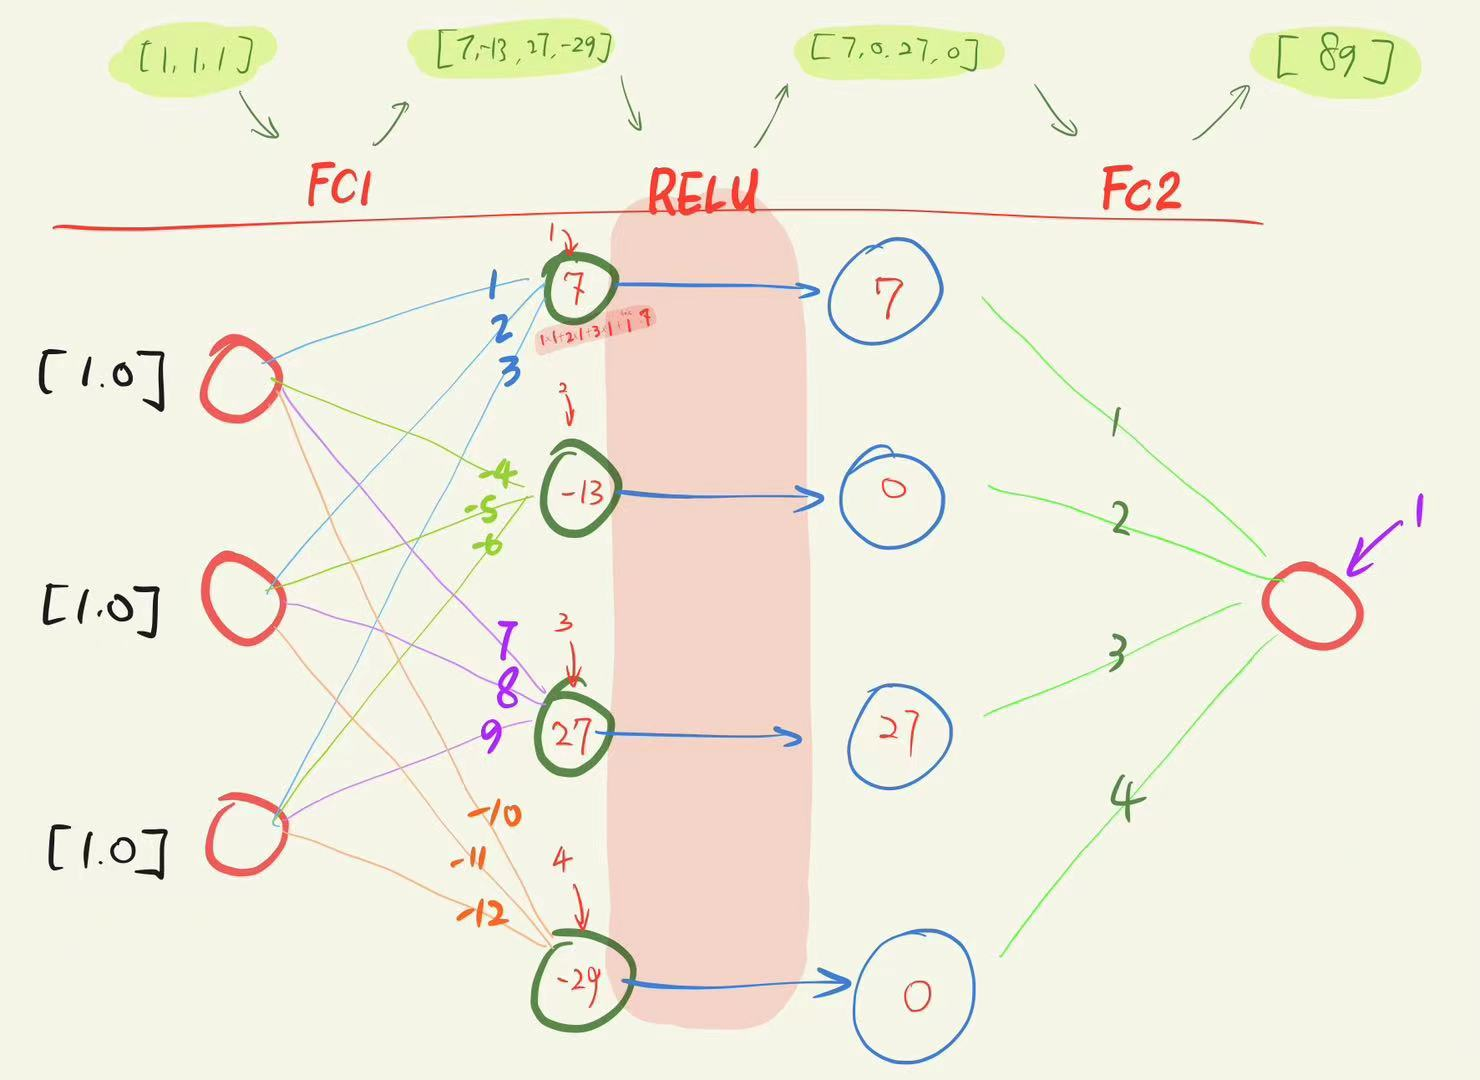

## register backward hook

`register_backward_hook` 的作用是获取神经网络反向传播过程中，各个模块输入端和输出端的梯度值。对于模块 module，其使用方式为：module.register_backward_hook(hook_fn) 。其中hook_fn的函数签名为：
```
hook_fn(module, grad_input, grad_output) 
    return Tensor or None
```
输入变量分别为：`模块`，`模块输入端的梯度`，`模块输出端的梯度`。
> 需要注意的是，<font color="red">这里的输入端和输出端，是站在前向传播的角度的，而不是反向传播的角度</font>。

例如线性模块：`o=W*x+b`，其输入端为 W，x 和 b，输出端为 o。


如果模块有多个输入或者输出的话，grad_input和grad_output可以是 `tuple` 类型。

对于线性模块：`o=W*x+b` ，它的输入端包括了W、x 和 b 三部分，因此 grad_input 就是一个包含三个元素的 `tuple`。

这里注意和 forward hook 的不同：

1. 在 forward hook 中，input 是 x，而不包括 W 和 b。

2. 返回 Tensor 或者 None， 
  > backward hook 函数不能直接改变它的输入变量，但是可以返回新的 grad_input，反向传播到它上一个模块。


In [ ]:

# Backward

import torch
from torch import nn


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(4, 1)
        self.initialize()

    def initialize(self):
        with torch.no_grad():
            self.fc1.weight = torch.nn.Parameter(
                torch.Tensor([[1., 2., 3.],
                              [-4., -5., -6.],
                              [7., 8., 9.],
                              [-10., -11., -12.]]))

            self.fc1.bias = torch.nn.Parameter(torch.Tensor([1.0, 2.0, 3.0, 4.0]))
            self.fc2.weight = torch.nn.Parameter(torch.Tensor([[1.0, 2.0, 3.0, 4.0]]))
            self.fc2.bias = torch.nn.Parameter(torch.Tensor([1.0]))

    def forward(self, x):
        o = self.fc1(x)
        o = self.relu1(o)
        o = self.fc2(o)
        return o


total_grad_out = []
total_grad_in = []


def hook_fn_backward(module, grad_input, grad_output):
    print(module) # 为了区分模块
    # 为了符合反向传播的顺序，我们先打印 grad_output
    print('grad_output', grad_output) 
    # 再打印 grad_input
    print('grad_input', grad_input)
    # 保存到全局变量
    total_grad_in.append(grad_input)
    total_grad_out.append(grad_output)


model = Model()

modules = model.named_children()
for name, module in modules:
    module.register_backward_hook(hook_fn_backward)

# 这里的 requires_grad 很重要，如果不加，backward hook 执行到第一层，对 x 的导数将为 None，
# 某英文博客作者这里疏忽了
# 此外再强调一遍 x 的维度，一定不能写成 torch.Tensor([1.0, 1.0, 1.0]).requires_grad_()
# 否则 backward hook 会出问题。

x = torch.Tensor([[1.0, 1.0, 1.0]]).requires_grad_()
o = model(x)
o.backward()

print('==========Saved inputs and outputs==========')
for idx in range(len(total_grad_in)):
    print('grad output: ', total_grad_out[idx])
    print('grad input: ', total_grad_in[idx])


# output:
'''
Linear(in_features=4, out_features=1, bias=True)
grad_output (tensor([[1.]]),)
grad_input (tensor([1.]),     ------------------------------> bias导数
      tensor([[1., 2., 3., 4.]]),    ----------------> input导数
      tensor([[ 7.], [ 0.], [27.], [ 0.]]))  -------> weights导数

ReLU()
grad_output (tensor([[1., 2., 3., 4.]]),)
grad_input (tensor([[1., 0., 3., 0.]]),)
## ReLU 层反向传播时，只有输入大于 0 的位置，才会有梯度传回来，输入小于等于 0 的位置不再有梯度反传

Linear(in_features=3, out_features=4, bias=True)
grad_output (tensor([[1., 0., 3., 0.]]),)
grad_input ( tensor([1., 0., 3., 0.]),       ------------------------------> bias导数
       tensor([[22., 26., 30.]]),       ------------------------------> input导数
       tensor([[1., 0., 3., 0.],  [1., 0., 3., 0.],  [1., 0., 3., 0.]])) -------> weights导数
'''

Linear(in_features=4, out_features=1, bias=True)
grad_output (tensor([[1.]]),)
grad_input (tensor([1.]), tensor([[1., 2., 3., 4.]]), tensor([[ 7.],
        [ 0.],
        [27.],
        [ 0.]]))
ReLU()
grad_output (tensor([[1., 2., 3., 4.]]),)
grad_input (tensor([[1., 0., 3., 0.]]),)
Linear(in_features=3, out_features=4, bias=True)
grad_output (tensor([[1., 0., 3., 0.]]),)
grad_input (tensor([1., 0., 3., 0.]), tensor([[22., 26., 30.]]), tensor([[1., 0., 3., 0.],
        [1., 0., 3., 0.],
        [1., 0., 3., 0.]]))
==========Saved inputs and outputs==========
grad output:  (tensor([[1.]]),)
grad input:  (tensor([1.]), tensor([[1., 2., 3., 4.]]), tensor([[ 7.],
        [ 0.],
        [27.],
        [ 0.]]))
grad output:  (tensor([[1., 2., 3., 4.]]),)
grad input:  (tensor([[1., 0., 3., 0.]]),)
grad output:  (tensor([[1., 0., 3., 0.]]),)
grad input:  (tensor([1., 0., 3., 0.]), tensor([[22., 26., 30.]]), tensor([[1., 0., 3., 0.],
        [1., 0., 3., 0.],
        [1., 0., 3., 0.]]))


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


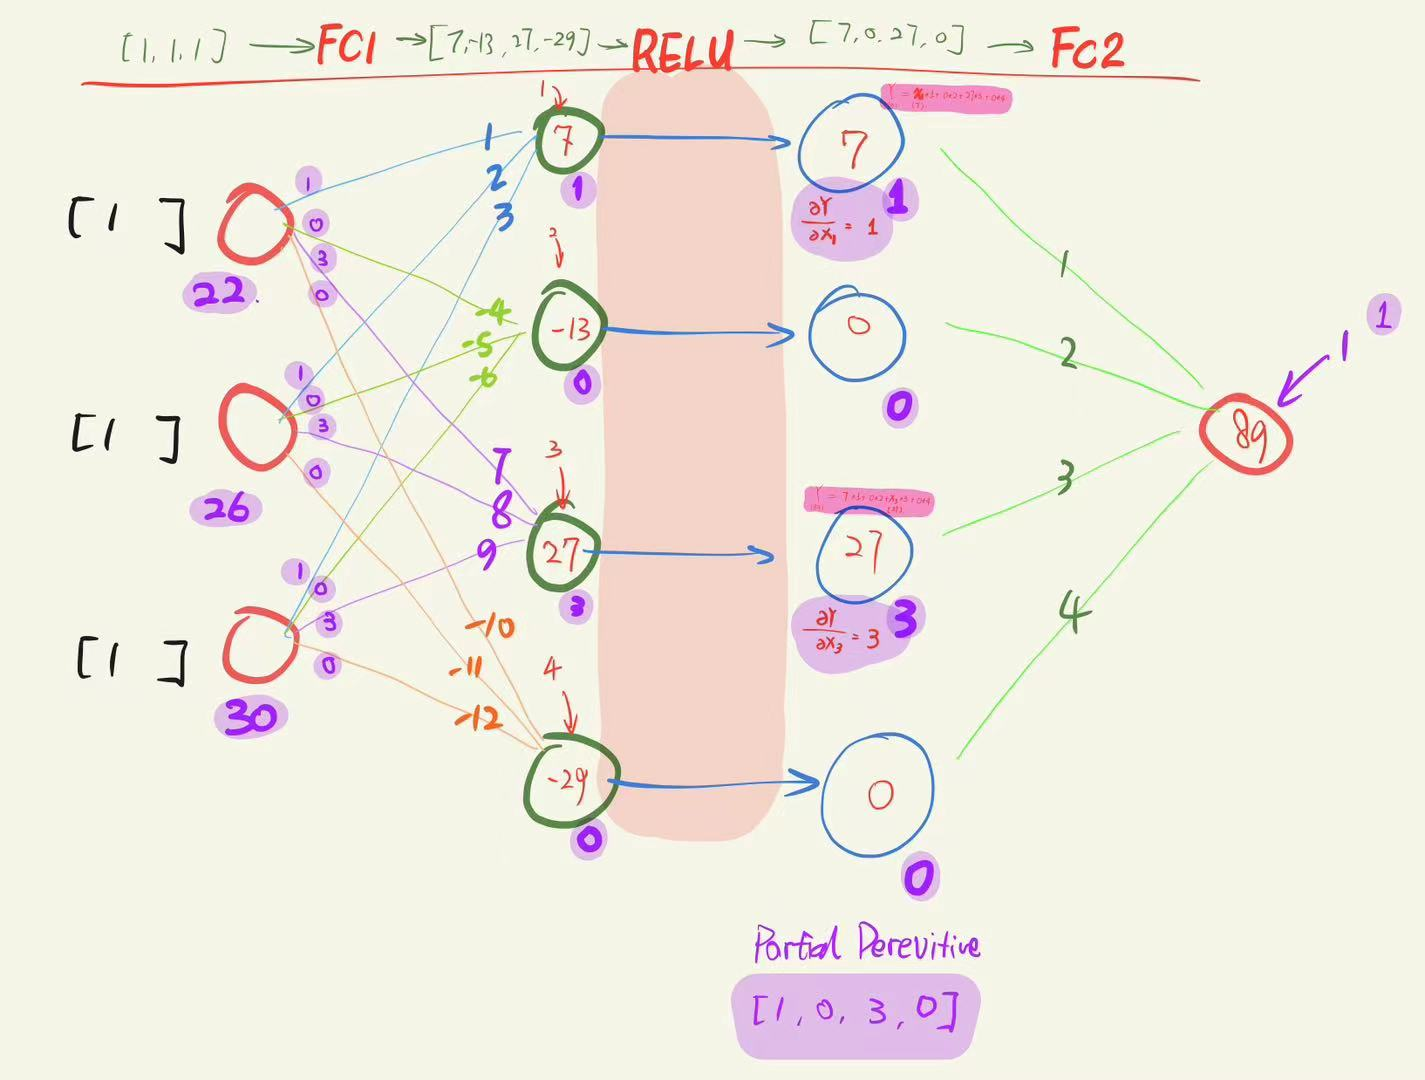